# Data Exploration: Ligand Poses

In [27]:
import polaris as po
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import fastpdb
import datamol as dm
import nglview as nv

competition = po.load_competition("asap-discovery/antiviral-ligand-poses-2025")
competition.cache()

2025-02-02 19:40:16.150 | WARNING  | polaris.dataset._base:zarr_root:179 - You're loading data from a remote location. If the dataset is small enough, consider caching the dataset first using CompetitionSpecification.cache() for more performant data access.
2025-02-02 19:40:16.738 | INFO     | polaris.dataset._base:_cache_zarr:374 - Copying Zarr archive to /Users/ellena/Library/Caches/polaris/datasets/ef344bf9-8662-4226-b74b-1e771a9a2103/data.zarr. This may take a while.
2025-02-02 19:40:24.630 | INFO     | polaris.hub.storage:copy_to_destination:177 - Copied 200 (159.41 MiB), skipped 0, of 476 keys. 42.02% completed.
2025-02-02 19:40:30.100 | INFO     | polaris.hub.storage:copy_to_destination:177 - Copied 400 (240.17 MiB), skipped 0, of 476 keys. 84.03% completed.
2025-02-02 19:40:33.216 | INFO     | polaris.hub.storage:copy_to_destination:177 - Copied 476 (318.38 MiB), skipped 0, of 476 keys. 100.00% completed.


'/Users/ellena/Library/Caches/polaris/datasets/ef344bf9-8662-4226-b74b-1e771a9a2103'

## Data

| Column               | Dtype                      | Description  |
|----------------------|---------------------------|-------------|
| Chain A Sequence    | str                        | Primary structure of the protein's A chain: A linear sequence of amino acids. |
| Chain B Sequence    | str                        | Primary structure of the protein's B chain, if any: A linear sequence of amino acids. |
| CXSMILES            | str                        | Text representation of the 2D molecular structure |
| Complex Structure   | PDB (`fastpdb.AtomArray`)  | 3D system of the ligand bound to the protein, prepared using OESpruce and aligned to a reference Mpro |
| Protein Structure   | PDB (`fastpdb.AtomArray`)  | 3D system of just the protein structure, prepared using OESpruce and aligned to a reference Mpro |
| Ligand Pose        | SDF (`rdkit.Chem.Mol`)     | 3D conformation of the molecule, bound to the protein |
| Protein Label      | str                        | `SARS-CoV-2 Mpro` or `MERS-CoV Mpro` |


In [28]:
train, test = competition.get_train_test_split()

df_train_X = pd.DataFrame(train.X)
df_test_X = pd.DataFrame(test.X)

print(f"Train size: {len(df_train_X)}")
print(f"Test size:  {len(df_test_X)}")

Train size: 770
Test size:  195


**Train Data**

In [29]:
print("Protein")
print(f"Unique Chain A Sequences: {len(df_train_X['Chain A Sequence'].unique())}")
print(f"Unique Chain B Sequences: {len(df_train_X['Chain B Sequence'].unique())}")
print(f"Samples with identical Chain A and Chain B Sequence: {len(df_train_X[df_train_X['Chain A Sequence'] == df_train_X['Chain B Sequence']])}")
print('-'*60)
print("Ligand")
print(f"Unique CXSMILES: {len(df_train_X['CXSMILES'].unique())}\n")

# Add column with Chain A and Chain B Sequence Length
df_train_X['Chain A Sequence Length'] = df_train_X['Chain A Sequence'].apply(len)
df_train_X['Chain B Sequence Length'] = df_train_X['Chain B Sequence'].apply(len)

df_train_X

Protein
Unique Chain A Sequences: 17
Unique Chain B Sequences: 27
Samples with identical Chain A and Chain B Sequence: 428
------------------------------------------------------------
Ligand
Unique CXSMILES: 568



,Chain A Sequence,Protein Label,Chain B Sequence,CXSMILES,Chain A Sequence Length,Chain B Sequence Length
0,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,c1ccc(SCC[NH+]2CCOCC2)cc1,304,304
1,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,O=C(Cc1cccc(Cl)c1)Nc1cncc2ccncc12,304,304
2,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIEDM...,C[C@@]1(C(=O)Nc2cncc3ccccc23)CNS(=O)(=O)c2ccc(...,305,302
3,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVINYE...,CNC(=O)C[N@H+]1Cc2ccc(Cl)cc2[C@H](C(=O)Nc2cncc...,300,291
4,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICNP...,C[NH+](C)CCOc1ccc2cncc(NC(=O)Cc3cccc(Cl)c3)c2c1,300,299
...,...,...,...,...,...,...
765,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,N#Cc1cncc(NC(=O)Cc2cccnc2)c1,304,304
766,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,O=C(c1cc(=O)[nH]c(=O)[nH]1)N1CCN(c2ccc(CO)c(Cl...,306,306
767,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,O=C(Cc1cccnc1)Nc1cccc(O[C@H]2CC(=O)N2)c1,304,304
768,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CC(=O)N1CC[NH+](Cc2cccc(C)c2)CC1,304,304


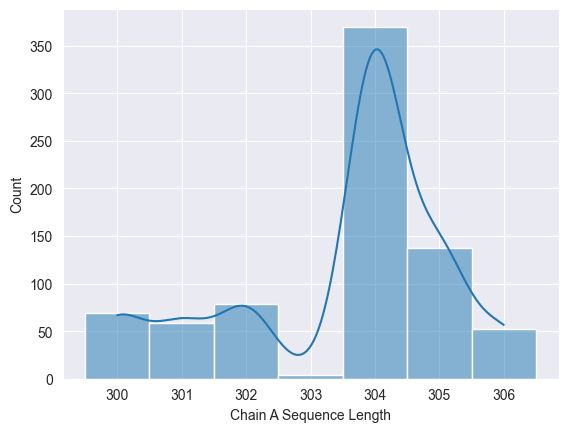

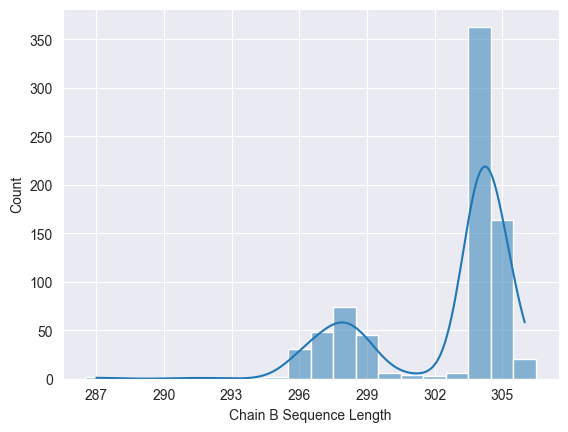

In [30]:
# Protein Chain A and Chain B Sequence Length for SARS-CoV-2 Mpro
sns.histplot(df_train_X['Chain A Sequence Length'], discrete=True, kde=True)
plt.show()

sns.histplot(df_train_X['Chain B Sequence Length'], discrete=True, kde=True)
plt.xticks(range(min(df_train_X['Chain B Sequence Length']), max(df_train_X['Chain B Sequence Length']) + 1, 3))
plt.show()

**Test Data**

In [31]:
print("Protein")
print(f"Unique Chain A Sequences: {len(df_test_X['Chain A Sequence'].unique())}")
print(f"Unique Chain B Sequences: {len(df_test_X['Chain B Sequence'].unique())}")
print(f"Samples with identical Chain A and Chain B Sequence: {len(df_test_X[df_test_X['Chain A Sequence'] == df_test_X['Chain B Sequence']])}")
print('-'*60)
print("Ligand")
print(f"Unique CXSMILES: {len(df_test_X['CXSMILES'].unique())}")
print('-'*60)
print("Protein Label")
print(f"SARS-CoV-2 Mpro Count: {len(df_test_X[df_test_X['Protein Label'] == 'SARS-CoV-2 Mpro'])}")
print(f"MERS-CoV Mpro Count:   {len(df_test_X[df_test_X['Protein Label'] == 'MERS-CoV Mpro'])}\n")

# Add column with Chain A and Chain B Sequence Length
df_test_X['Chain A Sequence Length'] = df_test_X['Chain A Sequence'].apply(len)
df_test_X['Chain B Sequence Length'] = df_test_X['Chain B Sequence'].apply(len)

df_test_X

Protein
Unique Chain A Sequences: 5
Unique Chain B Sequences: 8
Samples with identical Chain A and Chain B Sequence: 167
------------------------------------------------------------
Ligand
Unique CXSMILES: 161
------------------------------------------------------------
Protein Label
SARS-CoV-2 Mpro Count: 98
MERS-CoV Mpro Count:   97



,Chain A Sequence,Protein Label,Chain B Sequence,CXSMILES,Chain A Sequence Length,Chain B Sequence Length
0,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1nnco1)C(=O)N(c1cn...,303,303
1,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,COc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)cc1,303,303
2,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,305,305
3,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,303,303
4,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1ccnnc1)C(=O)N(c1c...,303,303
...,...,...,...,...,...,...
190,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CNS(=O)(=O)OCC(=O)N[C@@H](C)c1cc(Cl)cc(-c2ccc(...,305,305
191,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,305,305
192,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,MERS-CoV Mpro,SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPA...,O=C(Cc1cncc2ccccc12)NCc1cccc(Cl)c1,303,303
193,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,SARS-CoV-2 Mpro,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,305,305


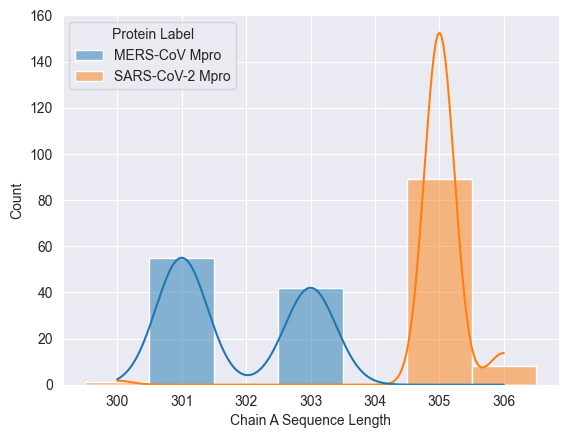

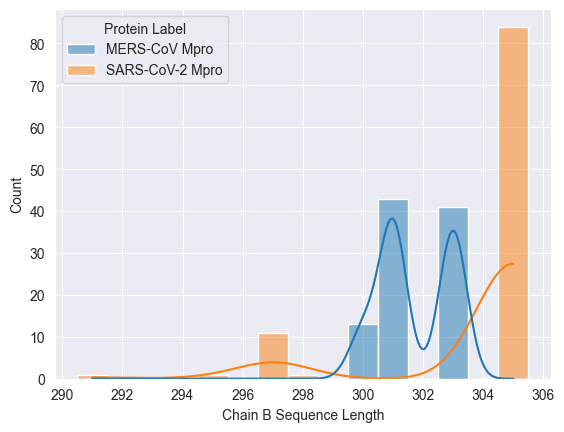

In [32]:
# Protein Chain A and Chain B Sequence Length for SARS-CoV-2 Mpro and MERS-CoV Mpro
sns.histplot(data=df_test_X, x='Chain A Sequence Length', hue='Protein Label', kde=True, discrete=True)
plt.show()

sns.histplot(data=df_test_X, x='Chain B Sequence Length', hue='Protein Label', kde=True, discrete=True)
plt.show()

In [33]:
# Similarity between MERS and SARS-CoV-2 Mpro Chain A Sequence for two chosen samples
# TODO: Sequence Alignment
mers = df_test_X.iloc[0]['Chain A Sequence']
sars = df_test_X.iloc[2]['Chain A Sequence']

matching_aas = sum(1 for i in range(len(mers)) if mers[i] == sars[i])
print(f'Sequence Similarity: {matching_aas/len(sars)}')

Sequence Similarity: 0.2459016393442623


**Ligand**

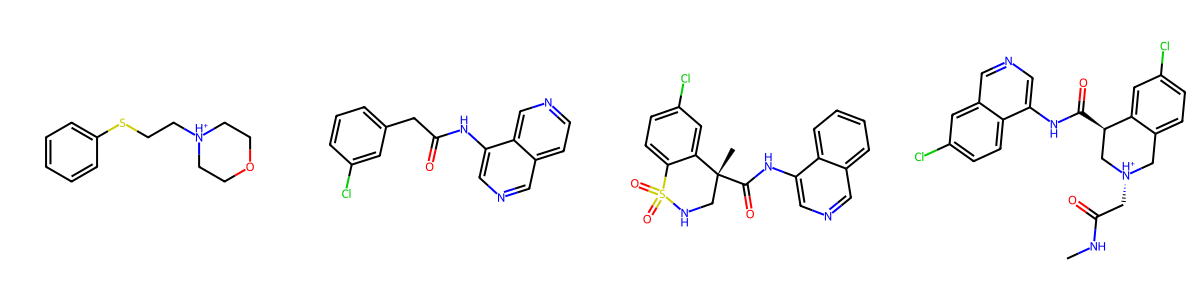

In [34]:
train_y = train.y
train_mols = [Chem.MolFromSmiles(df_train_X['CXSMILES'].iloc[i]) for i in range(len(df_train_X))]
test_mols = [Chem.MolFromSmiles(df_test_X['CXSMILES'].iloc[i]) for i in range(len(df_test_X))]

# First 4 ligands in train set
Draw.MolsToGridImage(train_mols[:4], molsPerRow=4, subImgSize=(300, 300))

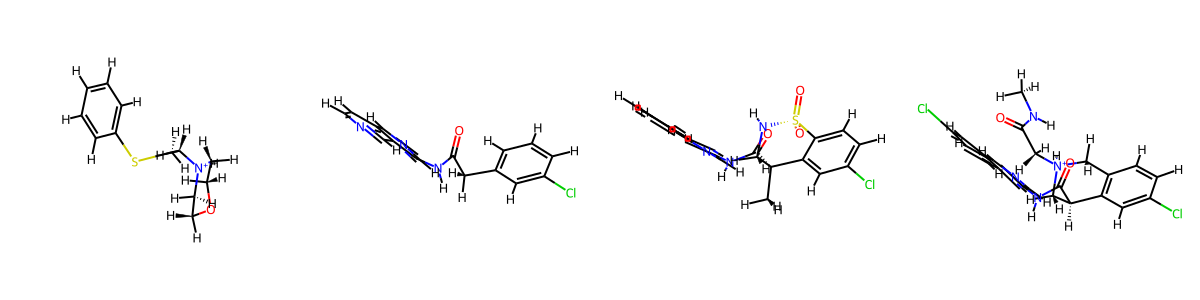

In [35]:
# First 4 ligands in train set in correct pose for docking
Draw.MolsToGridImage(train_y[:4], molsPerRow=4, subImgSize=(300, 300))

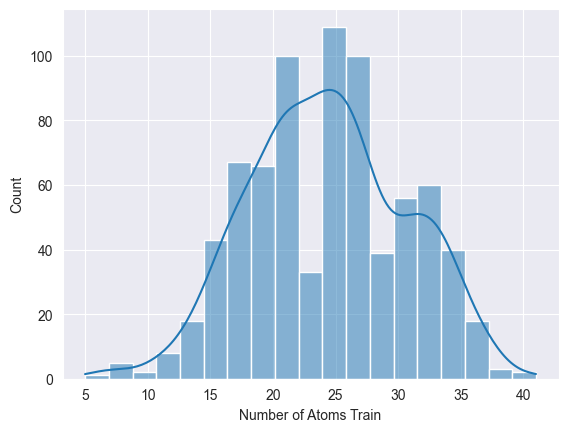

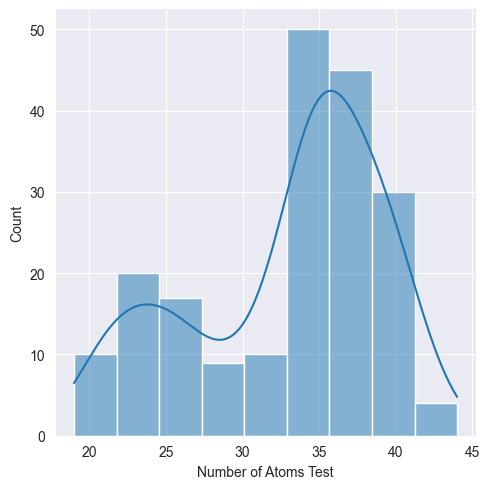

In [36]:
# Number of atoms in ligand (Credits to Franka (: )
sns.histplot(data=pd.DataFrame({"Number of Atoms Train":  [mol.GetNumAtoms() for mol in train_mols]}), x="Number of Atoms Train", kde=True)
plt.show()

sns.displot(data=pd.DataFrame({"Number of Atoms Test":  [mol.GetNumAtoms() for mol in test_mols]}), x="Number of Atoms Test", kde=True)
plt.show()

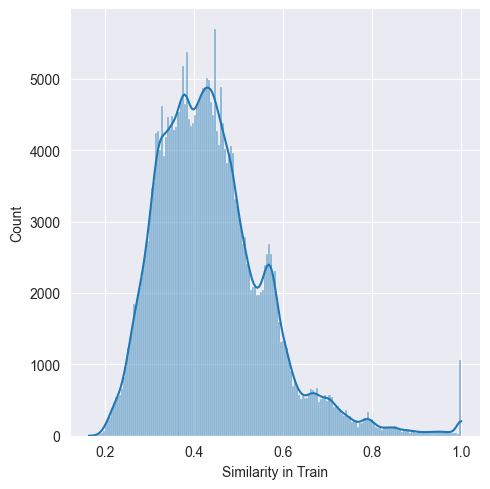

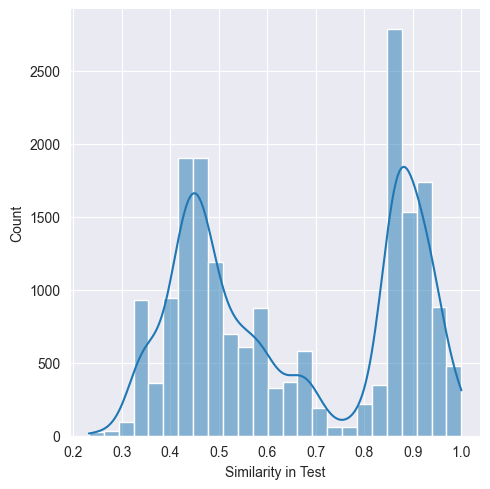

In [37]:
# Similarity within train and test set (Credits to Franka (: )
train_fps = [FingerprintMols.FingerprintMol(mol) for mol in train_mols]
test_fps = [FingerprintMols.FingerprintMol(mol) for mol in test_mols]

train_sim = []
for i in range(len(train_fps)-1):
    for j in range(i, len(train_fps)):
        train_sim.append(DataStructs.TanimotoSimilarity(train_fps[i], train_fps[j]))

sns.displot(data=pd.DataFrame({"Similarity in Train": train_sim}), x="Similarity in Train", kde=True)
plt.show()

test_sim = []
for i in range(len(test_fps)-1):
    for j in range(i, len(test_fps)):
        test_sim.append(DataStructs.TanimotoSimilarity(test_fps[i], test_fps[j]))

sns.displot(data=pd.DataFrame({"Similarity in Test": test_sim}), x="Similarity in Test", kde=True)
plt.show()

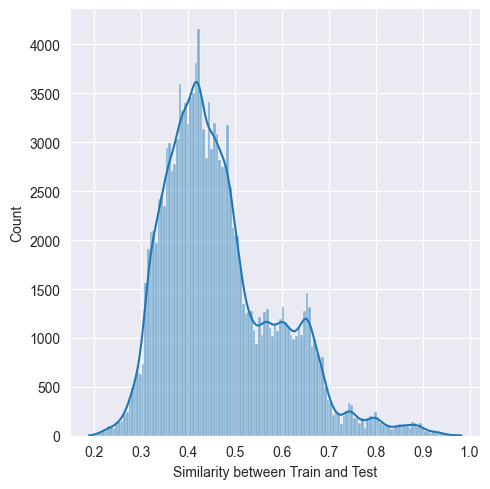

In [38]:
# Similarity between train and test (Credits to Franka (: )
sim = []
for i in range(len(train_fps)):
    for j in range(len(test_fps)):
        sim.append(DataStructs.TanimotoSimilarity(train_fps[i], test_fps[j]))

sns.displot(data=pd.DataFrame({"Similarity between Train and Test": sim}), x="Similarity between Train and Test", kde=True)
plt.show()

### Additional data for training

The dataset of the competition provides additional data for training: `Complex Structure` and `Protein Structure`.

In [39]:
datapoint = competition[2]

type(datapoint["Complex Structure"]), type(datapoint["Protein Structure"])

(biotite.structure.AtomArray, biotite.structure.AtomArray)

**Complex Structure**

In [40]:
# Write complex structure to PDB file and visualize it
pdb_file = fastpdb.PDBFile()
pdb_file.set_structure(datapoint["Complex Structure"])
pdb_file.write("complex.pdb")

complex_file = "complex.pdb"
view = nv.show_file(complex_file)
view

NGLWidget()

**Protein Structure**

In [41]:
# Write protein structure to PDB file and visualize it
pdb_file = fastpdb.PDBFile()
pdb_file.set_structure(datapoint["Protein Structure"])
pdb_file.write("protein.pdb")

protein_file = "protein.pdb"
view = nv.show_file(protein_file)
view

NGLWidget()